<a href="https://colab.research.google.com/github/SelimSavas/PyTorchImageSegmentation/blob/main/PyTorch_ImageSegmentation_Photo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Learning with PyTorch : Image Segmentation 

## Task 1 : Set up colab gpu runtime environment

In [64]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-efmc14si
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-efmc14si
  Resolved https://github.com/albumentations-team/albumentations to commit 9b0525f479509195a7a7b7c19311d8e63bbc6494
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [65]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


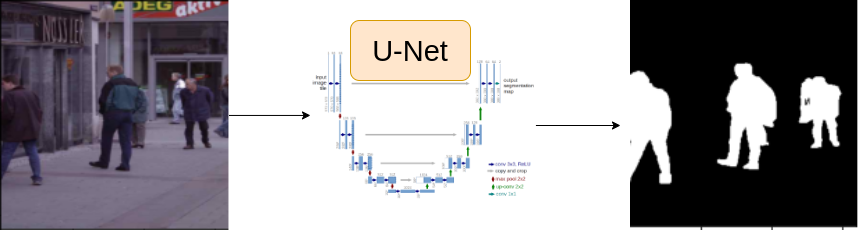

### Some Common Imports

In [66]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [67]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Task : 2 Setup Configurations

In [68]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'content'

DEVICE = 'cuda' #because we are using GPU
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [69]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [70]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

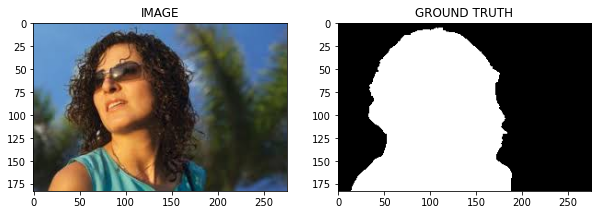

In [71]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [72]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [55]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
  ], is_check_shapes=False)    

## Task 4 : Create Custom Dataset 

In [73]:
from torch.utils.data import Dataset

In [57]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path =row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) -> (c, h, w)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask


In [58]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [59]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


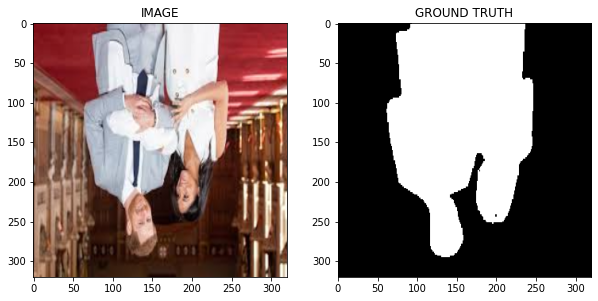

In [62]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

## Task 5 : Load dataset into batches

In [22]:
from torch.utils.data import DataLoader

In [63]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [24]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [25]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [26]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [27]:
class SegmentationModel (nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if mask != None:
      loss1 = DiceLoss(mode ='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [28]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

## Task 7 : Create Train and Validation Function 

In [29]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [30]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

## Task 8 : Train Model

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [32]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Saved Model
Epoch : 1 Train_loss : 0.7307003060976665 Valid_loss : 0.917052611708641


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Saved Model
Epoch : 2 Train_loss : 0.33949051002661385 Valid_loss : 0.2843214385211468


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Saved Model
Epoch : 3 Train_loss : 0.2960250665744146 Valid_loss : 0.27295736968517303


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch : 4 Train_loss : 0.2652506212393443 Valid_loss : 0.5153483152389526


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 5 Train_loss : 0.24580987095832824 Valid_loss : 0.33486806601285934


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Saved Model
Epoch : 6 Train_loss : 0.23270492355028788 Valid_loss : 0.23174476996064186


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 7 Train_loss : 0.19438065389792125 Valid_loss : 0.2538873180747032


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Saved Model
Epoch : 8 Train_loss : 0.1640290250380834 Valid_loss : 0.23051275312900543


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 9 Train_loss : 0.14752233872811 Valid_loss : 0.2691168114542961


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Saved Model
Epoch : 10 Train_loss : 0.15641132940848668 Valid_loss : 0.20027602836489677


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch : 11 Train_loss : 0.14913066526254018 Valid_loss : 0.21254074573516846


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Epoch : 12 Train_loss : 0.15612996915976207 Valid_loss : 0.20625736936926842


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Saved Model
Epoch : 13 Train_loss : 0.16212509820858637 Valid_loss : 0.19729739800095558


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 14 Train_loss : 0.13240268230438232 Valid_loss : 0.21849403716623783


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Saved Model
Epoch : 15 Train_loss : 0.10992260972658793 Valid_loss : 0.1605277843773365


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch : 16 Train_loss : 0.11140211423238118 Valid_loss : 0.16676347143948078


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 17 Train_loss : 0.11478456457455953 Valid_loss : 0.19113893061876297


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch : 18 Train_loss : 0.10898895412683487 Valid_loss : 0.1942582093179226


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 19 Train_loss : 0.13595724006493887 Valid_loss : 0.2019529528915882


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 20 Train_loss : 0.1903744046886762 Valid_loss : 0.2800253927707672


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 21 Train_loss : 0.15928038309017817 Valid_loss : 0.20753701031208038


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 22 Train_loss : 0.1331683893998464 Valid_loss : 0.18105390667915344


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Epoch : 23 Train_loss : 0.1323139136036237 Valid_loss : 0.19186991453170776


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 24 Train_loss : 0.127724556128184 Valid_loss : 0.17669153958559036


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

Epoch : 25 Train_loss : 0.13372893134752908 Valid_loss : 0.22551962174475193


## Task 9 : Inference

In [95]:
trainset[1][0].to(DEVICE).unsqueeze(0).shape

torch.Size([1, 3, 320, 320])

In [110]:
idx = 1

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
#logits_mask = model(image, mask)
logits_mask = model(image.to(DEVICE).unsqueeze(0),mask.to(DEVICE).unsqueeze(0)) #(C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5)*1.0

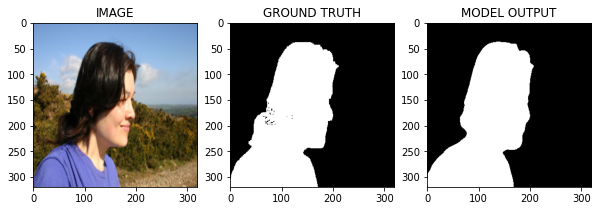

In [111]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))